<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#6fa8dc; overflow:hidden"><b> What to diffuse? Free coco annotations! </b></div>

|![https://github.com/JPABotermans/KaggleNotebooks/blob/main/Controlnet.png?raw=true](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Controlnet.png?raw=true)|
|:--:| 

<div style="padding: 20px; border-color: #a61d2f; border-radius: 0px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #6fa8dc; width: 75%; margin: 0 auto; background-color: #6fa8dc;">
    <p style="font-size: 20px; font-family: 'Georgia'; line-height: 1.5em;">
    Training deep learning models requires labelled data, and labelling data is expensive. So why don’t we use diffusion models to generate this data for free? This is what this tutorial is all about, <strong><u>generating free coco annotations using controlnet</u></strong>, an opensource model available on hugging face.  
</div>

To sumarise, in this notebook I will;
1. Explain some of the theory behind Controlnet from the paper. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)  
2. Import the controlnet implementation from [🤗Hugginface](https://huggingface.co/CompVis/stable-diffusion-v-1-4-original)
3. Contidion it with simple edges to show how you can work with controlnet.
4. Show some examples of the dataset we use as [background dataset](https://www.kaggle.com/datasets/arnaud58/landscape-pictures).
5. Explain how we make the masks and condition the diffusion process.
6. Generate the data.
7. And stores this data in the __coco format__, such that one can use it to train object detection models.

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#6fa8dc; overflow:hidden"><b> Theory behind Controlnet </b></div>
| ![https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/wat.png?raw=true](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/wat.png?raw=true) |
|--| 
A vanilla diffusion model can generates images by consecutively adding features to noise, starting in the beginning with courser features and sequentially moving to more fine-grained that correspond to details. This is similar how a human being paints, it starts with the rough edges and then consecutively adds details until the painting is finished. Except that a human painter wouldn’t start with gaussian noise, but with a white canvas. For a statistical model, white gaussian noise is the equivalent to an empty canvas. 

## How does this work?

As already mentioned before, a diffusion model uses the assumption that images can be constructed and destructed in a stochastic process by sequentially adding or removing noise. That destructive process (the forward process) is the easy part, since you can easily show that by starting with an image and just adding noise. During training a model is trained to reverse this process, hence a the reverse process is often called denoising. Then, after training this model is used to generate a sample beginning with white Gaussian noise.

## Control net


Control net is a diffusion model that employs a specific architecture that enables a more fine-grained type of control to its output, it simply allows users to add a certain pattern to its input and therefor sets specific conditions on its output. This allows us to use it to easily generate data with a specific set of conditions. These visual conditions can be edges, masks or just prompts. One example is conditioning an image on a edges, in the image you can see how that works for edges.
Easy because often these visual conditions/constrains are easier to generate procedurally then generate a picture. Which is exactly how we will generate a labelled dataset of flying things, without labelling ourselves. That is, we will first generate visual conditionings of objects (masks), and then use control net to inpatient these specific objects into images with random backgrounds. In this way we just derive the bounding boxes and annotations from the masks that we used in the first place.
 

##  How does one get a controlnet?
Control net is not a model trained from scratch, it is a technique that adds specific block to a previously trained diffusion model. That block can be any learned computational block. In the case of Stable Diffusion this is a convolution block with attention. This allows you to just fine-tune with relatively ease a model like stable-diffusion on a consumer grade GPU, like the P100 which are available on kaggle.

| ![https://github.com/lllyasviel/ControlNet/blob/main/github_page/he.png?raw=true](https://github.com/lllyasviel/ControlNet/blob/main/github_page/he.png?raw=true) | 
|:--:| 
| From: [github of lllyasviel](https://github.com/lllyasviel/ControlNet/blob/main/github_page/he.png?raw=true)|


## Some available Controlnets
- Text-to-image, except for getting an text-prompt to guide the diffusion process, this model also accepts an image with edges and has learned how to "fill in" the rest of the image. The image above shows this mode, and the code used to do this is given below.
- Image-to-image, a controlnet-model trained for this tasks accepts not just a prompt but also an initial image that it uses for "inspiration" to generate a new image. A depth map could be an example.
- Inpainting, this is the mode that we will use to make our syntethic data. This mode requires a __base image__, a __mask__ and a __control image__. 


In [1]:
# import the required libraries
import PIL
from PIL import Image, ImageDraw
import cv2
import numpy as np
import random
import os
import datetime
import torch
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler, DDIMScheduler, StableDiffusionControlNetPipeline
from diffusers.utils import load_image
import pycocotools
import pycocotools.mask
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import json
import matplotlib.patches as patches

2025-04-18 13:57:15.001696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744984635.232691      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744984635.301107      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the variables
img_h = 512
img_w = 512

base_background_dir = "/kaggle/input/landscape-pictures"
output_dir = "/kaggle/working/synthetic-flying-things/"
batch_size = 1
n_batches = 20
inference_steps = 50
classes = ['bird', 'hot air balloon', 'helicopter', 'mosquito', 'wasp']
os.makedirs(name=output_dir, exist_ok=True)
os.makedirs(name=output_dir + "images", exist_ok=True)
low_threshold = 250
high_threshold = 300

In [3]:
def generate_random_msk_np(size: tuple[int, int]) -> np.ndarray:
    """
    Generate a binary mask for a given fruit shape.

    Parameters:
    - shape_type (str): The type of fruit shape to generate.a
    - size (tuple[int, int]): The size of the image (width, height).

    Returns:
    - np.ndarray: A binary mask where the shape is represented by True values.
    """
    cx, cy = random.randint(10, int(size[0]-10)), random.randint(10, int(size[1]*0.4))
    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    
    width = random.randint(int(size[0]*0.1), int(size[0]*0.2))
    height = random.randint(int(size[1]*0.2), int(size[1]*0.3))
    draw.rectangle([cx-width//2, cy-height//2, cx+width//2, cy+height//2], fill=255)

    return np.array(mask) == 255

In [4]:
def get_base_coco_dict() -> dict:
    return {
    "info": {
        "description": "Synthetic flying things dataset , the background (landscape images) are licensed under CC0 1.0 Universal. The model used to generate (https://huggingface.co/lllyasviel/control_v11p_sd15_inpaint) is licensed under OpenRAIL.",
        "version": "1.0",
        "year": datetime.datetime.now().year,
        "contributor": "Koen Botermans",
        "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "bird", "supercategory": "shape"},
        {"id": 2, "name": "hot air balloon", "supercategory": "shape"},
        {"id": 3, "name": "helicopter", "supercategory": "shape"},
        {"id": 4, "name": "mosquito", "supercategory": "shape"},
        {"id": 5, "name": "wasp", "supercategory": "shape"},
    ]}
coco_data = get_base_coco_dict()
coco_name_to_id = {cat["name"]: cat["id"] for cat in coco_data["categories"]}

In [5]:
def get_random_dir(base_dir: str) -> str:
    return np.random.choice(os.listdir(base_dir))

In [6]:
def make_inpaint_condition(img_np: np.ndarray, msk_np: np.ndarray) -> torch.Tensor:
    img_np = img_np.copy().astype(np.float32) / 255.0
    msk_np = msk_np.astype(np.float32) 

    img_np[msk_np * 1.0 > 0.5] = -1.0
    return  img_np

In [7]:
def get_inputs(img_h: int, img_w: int, ) -> dict[str, np.ndarray]:
    background_img = f"{base_background_dir}/{get_random_dir(base_dir=base_background_dir)}"
    base_img = cv2.imread(background_img)[..., ::-1]
    cls_msk_np = generate_random_msk_np(size=(img_h, img_w))
    img_np = cv2.resize(base_img, (img_h, img_w), cv2.INTER_LINEAR)
    cnt_img_np = make_inpaint_condition(img_np=img_np.copy(), msk_np=cls_msk_np)
    return {
        "base_img_np": img_np,
        "cls_msk_np": cls_msk_np,
        "cnt_img_np": cnt_img_np,
    }

In [8]:
def msk_np_to_box(msk_np: np.ndarray) -> list[int]:
    """Given a msk_np, returns a bounding box in the coco format.
    COCO format = Coco/Pixel format:      [x_min, y_min, width, height]
    """
    y, x = np.where(msk_np)
    x_min = x.min()
    x_max = x.max()
    y_max = y.max()
    y_min = y.min()
    
    return [int(x_min), int(y_min), int(x_max-x_min), int(y_max-y_min)]

In [9]:
def get_coco_ann(ann_id: int, img_id: int, cat_id: int, msk_np: np.ndarray) -> dict[str, str | dict[str, tuple[int] | str]]:
    box_np = msk_np_to_box(msk_np=msk_np)
    return {
        "id": int(ann_id),
        "image_id": int(img_id),
        "category_id": int(cat_id),
        "area": int(box_np[2] * box_np[3]),
        "bbox": box_np,
        "iscrowd": int(0),
    }

In [10]:
def plot_inputs_dict(inputs_dict: dict[str, np.ndarray]) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow(inputs_dict["base_img_np"])
    axs[1].imshow(inputs_dict["cls_msk_np"][..., np.newaxis] * 255, cmap="gray")
    axs[2].imshow(inputs_dict["cnt_img_np"])
    axs[0].set_title("The base image")
    axs[1].set_title("The mask")
    axs[2].set_title("The control image")
    _ = [ax.axis("off") for ax in axs.flatten()]


In [11]:
def plot_inputs_dict_output(inputs_dict: dict[str, np.ndarray], output) -> None:
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    axs[0].imshow(inputs_dict["base_img_np"])
    axs[1].imshow(inputs_dict["cls_msk_np"][..., np.newaxis] * 255, cmap="gray")
    axs[2].imshow(inputs_dict["cnt_img_np"])
    axs[3].imshow(np.array(output))
    axs[0].set_title("The base image")
    axs[1].set_title("The mask")
    axs[2].set_title("The control image")
    axs[3].set_title("Output image")
    _ = [ax.axis("off") for ax in axs.flatten()]

In [12]:
def get_coco_img_ann(img_id: int, file_name: str, img_w: int, img_h: int) -> dict[str, int | str | float]:
    return {
        "id": int(img_id),
        "file_name": f"{output_dir}/images/img_{img_id}.png",
        "width": int(img_w),
        "height": int(img_h),
        "date_captured": str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")),
    }

In [13]:
def get_batch_inputs(batch_size: int)  -> list[list[str, np.ndarray, np.ndarray, np.ndarray]]:
    batch_base_img_np = []
    batch_cls_msk_np = []
    batch_cnt_img_np = []
    batch_cls_names = []
    for _ in range(batch_size):
        class_name = np.random.choice(classes)
        batch_cls_names.append(class_name)
        inputs_dict = get_inputs( img_h=img_h, img_w=img_w)
        batch_base_img_np.append(inputs_dict["base_img_np"]/255)
        batch_cls_msk_np.append(inputs_dict["cls_msk_np"] * 1.0)
        batch_cnt_img_np.append(inputs_dict["cnt_img_np"])
    return batch_base_img_np, batch_cls_msk_np, batch_cnt_img_np, batch_cls_names

In [14]:
def get_batch_outputs(batch_base_img_np, batch_cls_msk_np, batch_cls_img_np, batch_cls_names) -> list:
    return pipe(
        [f"A big {class_name} flying, extremely realistic" for class_name in batch_cls_names],
        negative_prompt=[f"Background, clouds, cartoons, "]* batch_size,
        num_inference_steps=inference_steps,
        eta=1.0,
        image=np.stack(batch_base_img_np),
        mask_image=np.stack(batch_cls_msk_np)[..., np.newaxis]* 1.0,
        control_image=np.stack(batch_cls_img_np),
    ).images

In [15]:
def plot_image_with_bboxes(coco: COCO, img_id: int, cat_ids=[1, 2, 3, 4, 5]):
    img_info = coco.loadImgs(img_id)[0]
    img_path = img_info['file_name']
    image = Image.open(img_path)

    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for ann in anns:
        bbox = ann['bbox']
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cat_id = ann['category_id']
        cat_name = coco.loadCats(cat_id)[0]['name']
        ax.text(x, y - 5, cat_name, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()


In [16]:
def plot_edge_example(original_image, canny_image, output) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    axs[0].imshow(np.array(original_image))
    axs[1].imshow(np.array(canny_image))
    axs[2].imshow(np.array(output))
    axs[0].set_title("Original image")
    axs[1].set_title("Input and conditioning")
    axs[2].set_title("Output")
    _ = [ax.axis("off") for ax in axs]

In [17]:
def convert_to_python_types(obj):
    if isinstance(obj, np.integer):
        return np.int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

In [18]:
def plot_background_images() -> None:
    backgournd_img1 = cv2.imread("/kaggle/input/landscape-pictures/00000000.jpg")[..., ::-1]
    backgournd_img2 = cv2.imread("/kaggle/input/landscape-pictures/00000000_(2).jpg")[..., ::-1]
    backgournd_img3 = cv2.imread("/kaggle/input/landscape-pictures/00000000_(3).jpg")[..., ::-1]
    backgournd_img4 = cv2.imread("/kaggle/input/landscape-pictures/00000000_(4).jpg")[..., ::-1]
    backgournd_img5 = cv2.imread("/kaggle/input/landscape-pictures/00000000_(5).jpg")[..., ::-1]
    fig, axs = plt.subplots(1, 5, figsize=(30, 10))
    axs[0].imshow(backgournd_img1)
    axs[1].imshow(backgournd_img2)
    axs[2].imshow(backgournd_img3)
    axs[3].imshow(backgournd_img4)
    axs[4].imshow(backgournd_img5)
    _ = [ax.axis("off") for ax in axs]

In [19]:
def get_canny_edge(image, low_threshold: int, high_threshold: int) -> PIL.Image:
    image = np.array(original_image)
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)


<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#6fa8dc; overflow:hidden"><b>Text-to-image with edges. </b></div>

This is the most basic controlnet. Where one simply adds an image with edges as "base" image. To get the results bewow one can simply download the `lllyasviel/sd-controlnet-canny` with its weight using and add that to a `StableDiffusionControlNetPipeline` that has as base model the `stable-diffusion-v1-5/stable-diffusion-v1-5`.

As you can see I simply;
1. Download an image using the `load_image` function.
2. Derive the edges using the `cv2.Canny`.
3. Download the weights for contornet and for stable-diffusion.
4. Let the model do its job.


In [20]:
# 1. load an image.
original_image = load_image(
    "https://i.kym-cdn.com/photos/images/original/000/173/576/Wat8.jpg"
)

# 2. Derive the edges
canny_image = get_canny_edge(image=original_image, low_threshold=low_threshold, high_threshold=high_threshold)

# 3. Download the weights for contornet and the base model (stable-diffusion)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    controlnet=controlnet, 
    torch_dtype=torch.float16, 
    use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# 4. Let the model do its job.
canny_output = pipe(
    "A grandmother being completely flabbergasted, looking at something in the distance", 
    image=canny_image
).images[0]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

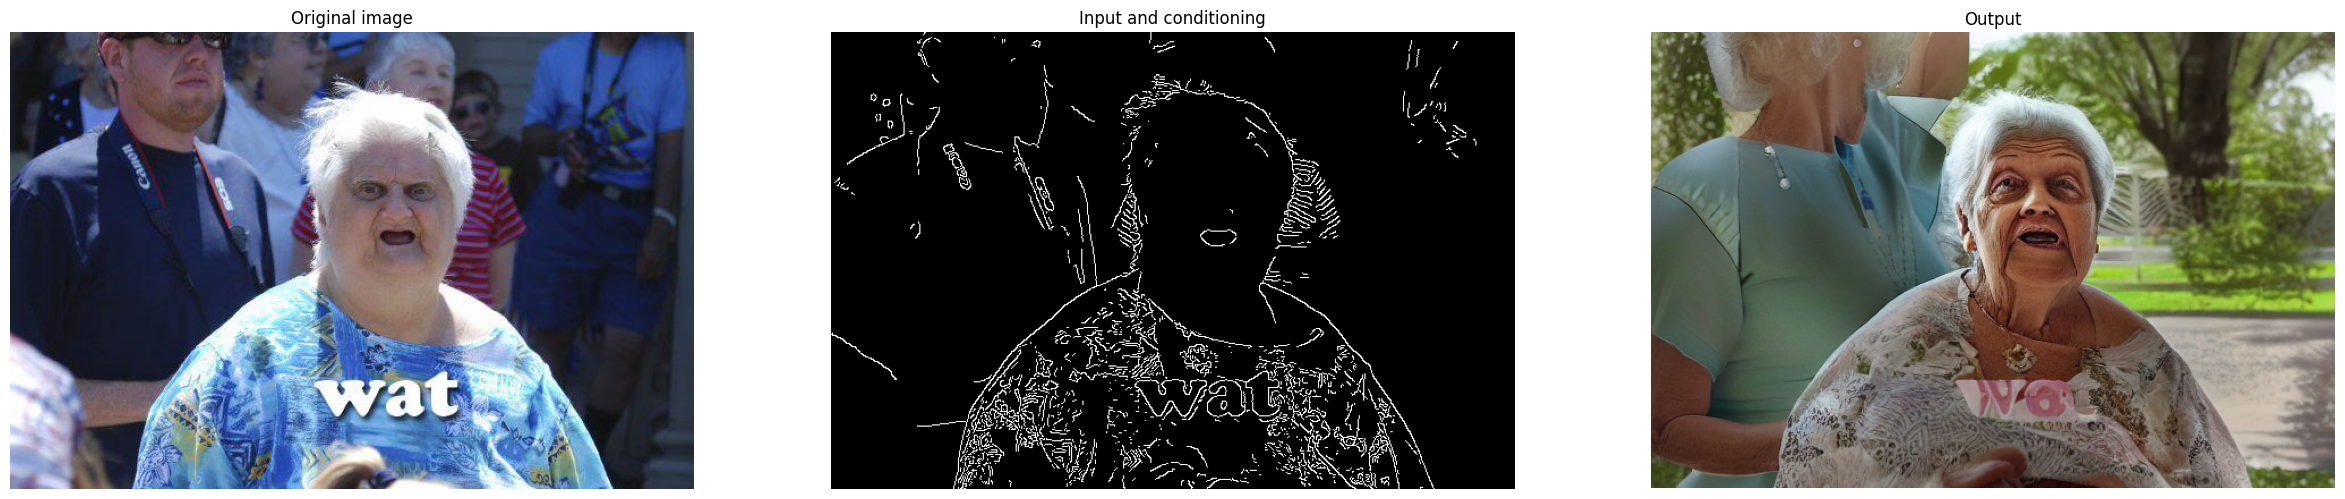

In [21]:
plot_edge_example(original_image, canny_image, canny_output) 

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#6fa8dc; overflow:hidden"><b>Generating coco annotations. </b></div>

To generate an annotated coco dataset you need the following;
1. The correct controlnet and stable diffusion weights from huggingface.
2. A background dataset. As mentioned above, controlnet that inpaints needs a base image which in which it can inpaint something.
3. Generate prompts and a conditioning.
    1. Prompts: those are straightforward, it will just be the class name of the object we want to inpaint followed with a basic extension.
    2. The **conditioning**, since we want to generate coco data we need to generate the conditioning in such a way that we can derive annotations from these masks. We will be doing this by simply generating a random box as conditioning, from which we can derive the bounding boxes. This is done in the functions `make_inpaint_condition` and `msk_np_to_box`. Except for a mask, controlnet also needs as input a control image. This is an image which is the same as the base image, except that it is set to the value of `-1` on place where the model should inpaint.

For this task we use the `lllyasviel/control_v11p_sd15_inpaint` model and use the `StableDiffusionControlNetInpaintPipeline` that has, again, uses as base model `stable-diffusion-v1-5/stable-diffusion-v1-5`.

In [22]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Background dataset
The dataset I use for background images is the [Landscape Pictures](https://www.kaggle.com/datasets/arnaud58/landscape-pictures/versions/2). It contains roughly 20k images, for each sample that I generate I simply sample one of these images and inpaint. I use this dataset because I am planning to inpaint things that fly, and I have noticed that general images from landscapes work better then for example indoor images. 

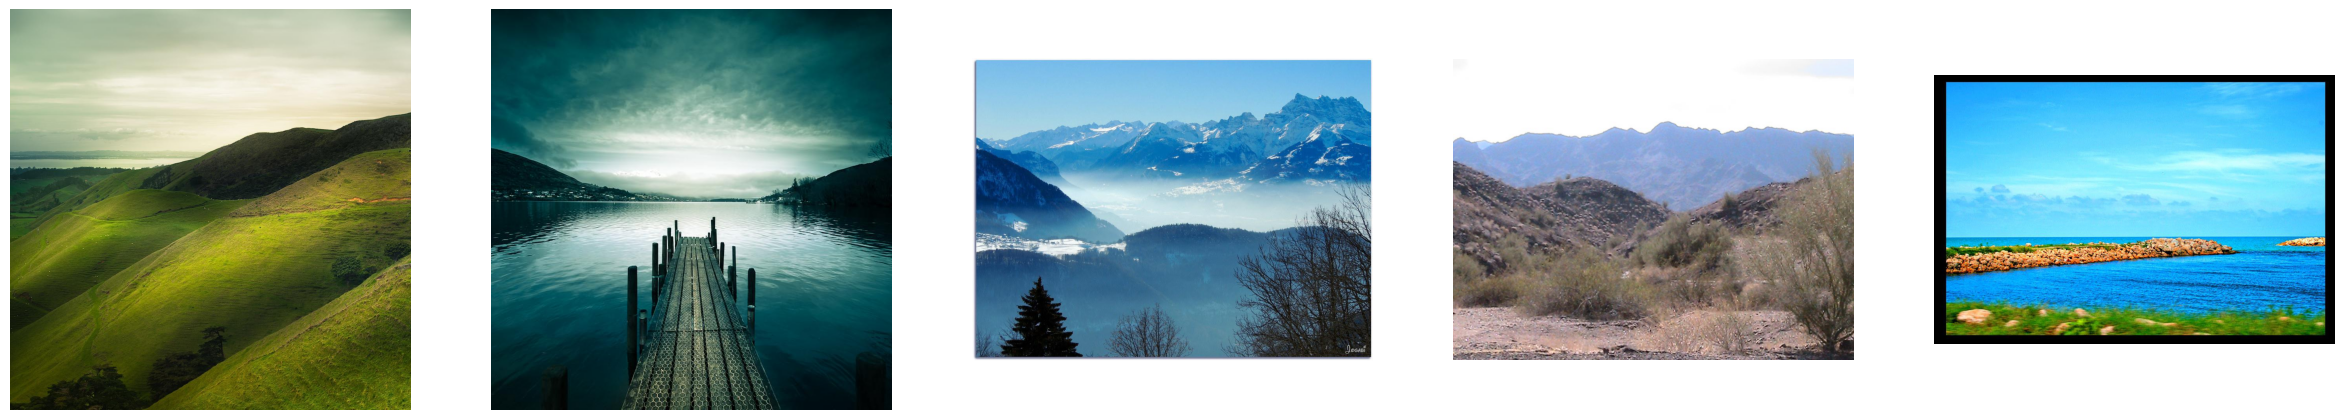

In [23]:
plot_background_images()

## Prompts and the conditioning
We will be inpainting images into the background flying things which can be one of the following things:

```['bird', 'hot air balloon', 'helicopter', 'mosquito', 'wasp']```

A string of these class names I insert into the following prompt: `A big {class_name} flying, extremely realistic, normal in its environment`.

Except for the prompt, the input of an inpainting-controlnet contains out of;

 - The base image, which is the model tries to inpaint something in. This is the starting point of the 
 - The mask, which is tells the model where to inpaint the prompt into. I will randomly generate masks in the shape of boxes, such that I can derive bounding boxes (the annotations) from these mask.
 - The control image, which provides guidance to the diffusion model during the generation process.

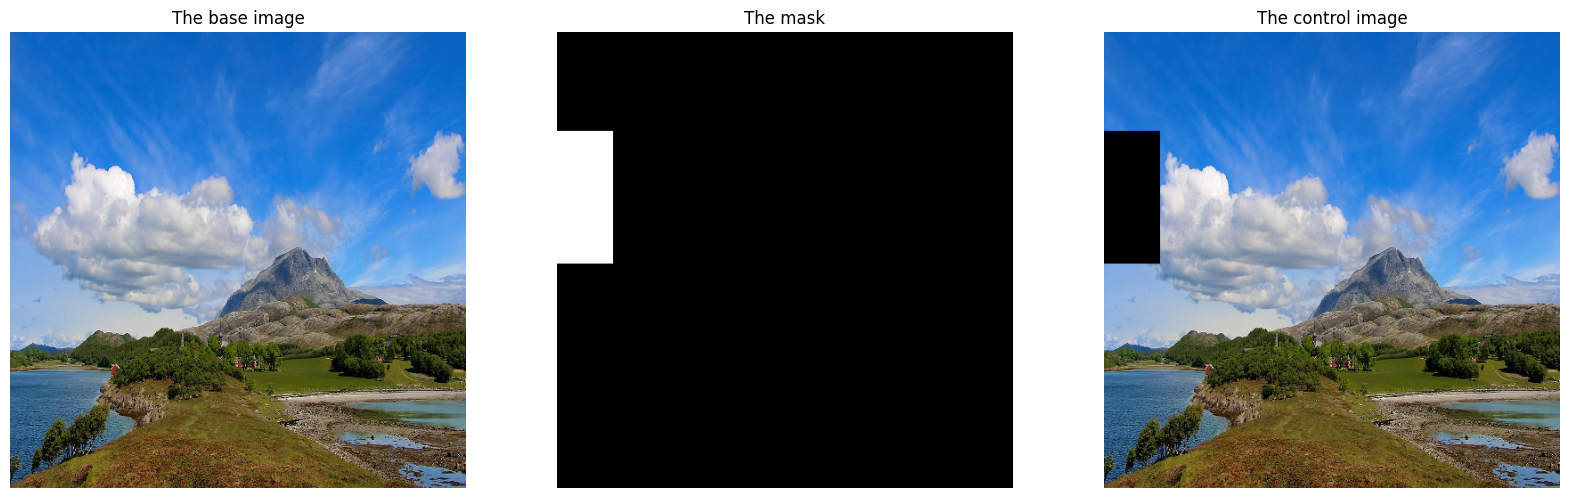

In [24]:
class_name = "hot air balloon"
inputs_dict = get_inputs(img_h, img_w)
plot_inputs_dict(inputs_dict)

## Example one image.
This is how you generate on image, as you can see the model takes as input the base_image, the control_image and the mask_image. 

In [25]:
output = pipe(
    [f"A big {class_name} flying, extremely realistic, normal in its environment."],
    negative_prompt=[f"Background, clouds, cartoons, nothing, scribbled"],
    num_inference_steps=50,
    image=[inputs_dict["base_img_np"]/255.0],
    mask_image=[inputs_dict["cls_msk_np"] * 1.0],
    control_image=[inputs_dict["cnt_img_np"]],
    num_images_per_prompt=1
).images

  0%|          | 0/50 [00:00<?, ?it/s]

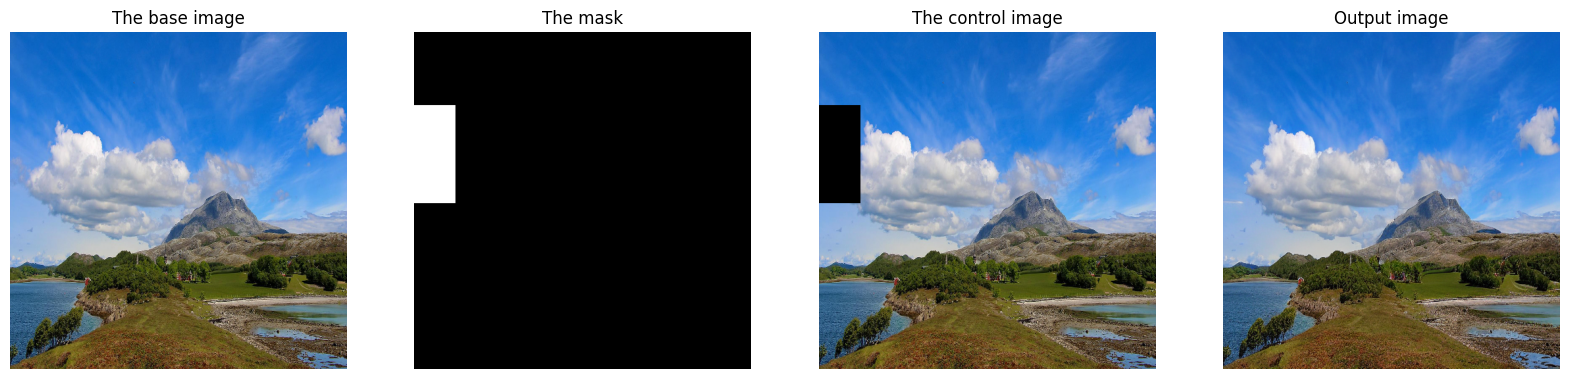

In [26]:
plot_inputs_dict_output(inputs_dict, output[0])

## Generating the complete coco dataset.

This is where I generate the complete coco dataset, as you can see I just randomly fetch base image and randomly generate masks and control images, then generate the images and derive annotations from them. During this loop I keep track of all my annotations and write the generated images to disk.

In [27]:
all_coco_annotations = []
coco_annotation_data = get_base_coco_dict()
img_id = 0
ann_id = 0
for batch_id in range(n_batches):
    batch_base_img_np, batch_cls_msk_np, batch_cls_img_np, batch_cls_names = get_batch_inputs(batch_size=batch_size)
    output = get_batch_outputs(batch_base_img_np, batch_cls_msk_np, batch_cls_img_np, batch_cls_names)
    for i, img in enumerate(output):
        img_file_name = f"{output_dir}/images/img_{img_id}.png"
        cv2.imwrite(img_file_name, np.array(img)[..., ::-1], )
        coco_annotation_data["annotations"].append(
            get_coco_ann(
                ann_id=ann_id,
                img_id=img_id,
                cat_id=coco_name_to_id[batch_cls_names[i]],
                msk_np=batch_cls_msk_np[i],
            )
        )
        coco_annotation_data["images"].append(
            get_coco_img_ann(
                img_id=img_id,
                file_name=img_file_name,
                img_w=img_w,
                img_h=img_h
            )
        )
        img_id += 1
        ann_id += 1

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Check the coco dataset and annotations.

So after how do our images look like?

In [28]:
coco_annotation_data = {k: convert_to_python_types(v) for k, v in coco_annotation_data.items()}
with open(output_dir + "annotations.json", "w") as file:
    json.dump(coco_annotation_data, file)
coco_gt = COCO("/kaggle/working/synthetic-flying-things/annotations.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [29]:
coco_gt = COCO("/kaggle/working/synthetic-flying-things/annotations.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


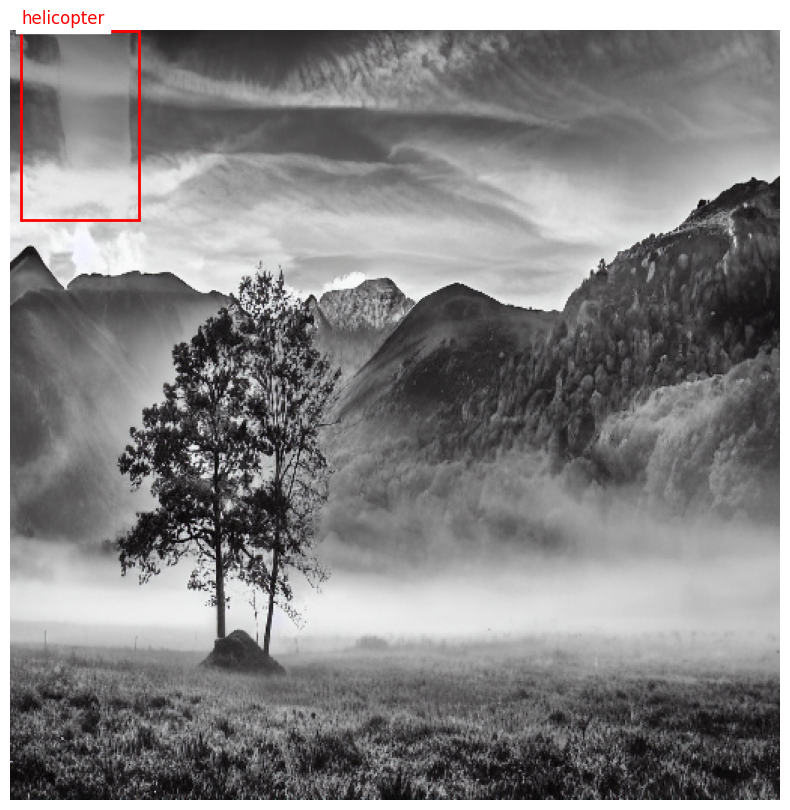

In [30]:
plot_image_with_bboxes(coco=coco_gt, img_id=0)